In [1]:
import pandas as pd
from yahoofinancials import YahooFinancials
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

This code imports several libraries and sets up a Jupyter Notebook environment for plotting graphs inline. Specifically:

- `pandas` is a library for data manipulation and analysis, commonly used for working with tabular data.
- `YahooFinancials` is a Python wrapper for the Yahoo Finance API that allows users to retrieve historical stock price data and other financial information for various assets.
- `datetime` is a module that provides classes for working with dates and times.
- `matplotlib.pyplot` is a plotting library for creating static, animated, and interactive visualizations in Python.
- `numpy` is a library for working with arrays and matrices of numerical data.

By using `%matplotlib inline`, it sets up the Jupyter Notebook environment to display Matplotlib plots inline.

This code snippet does not perform any actual operations. It simply imports necessary libraries and sets up the environment for data retrieval and visualization.

In [2]:
ticker = "^NSEI"
yahoo_financials = YahooFinancials(ticker)
end_date = datetime.datetime.now()
df = yahoo_financials.get_historical_price_data("2013-01-01", end_date.strftime('%Y-%m-%d'), "daily")
df = pd.DataFrame(df[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
df = df.reset_index()
df = df[['formatted_date', 'high',  'low',  'open',  'close']]
df = df.dropna()

The code sets the ticker symbol for the National Stock Exchange of India (NSEI) and imports data for its historical price data from Yahoo Finance. The date range for the data is set from January 1, 2013, to the current date. 

The `yahoo_financials.get_historical_price_data()` method is used to retrieve the historical price data and returns a dictionary containing the data for the specified ticker symbol. The `pd.DataFrame()` method is used to convert the dictionary into a Pandas DataFrame. 

The DataFrame is then modified by dropping the `date` column and setting the index to the `formatted_date` column. This results in a DataFrame with the daily historical prices for the NSEI, indexed by date.

In [3]:
df = df.reset_index()
df = df[['formatted_date','high', 'low', 'open', 'close']]
df = df.dropna()

This code manipulates the pandas DataFrame `df` which contains historical daily stock prices data for a given stock. 

`df.reset_index()` resets the index of the DataFrame, which currently is the formatted date of the historical price data.

`df[['formatted_date','high', 'low', 'open', 'close']]` selects only the columns related to date and the price metrics that are relevant for stock analysis (high, low, open, close).

`df.dropna()` removes any rows with missing data (NaN) from the DataFrame. 

In summary, this code restructures the DataFrame to have the date in one column, and the relevant price metrics (high, low, open, close) in separate columns, and removes any rows with missing data. This restructured DataFrame is then used for further analysis or visualization of the stock price data.

# Lets start modeling the long-short memomry model

In [4]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

The code imports two important libraries used for building a machine learning model for time series forecasting:

1. `MinMaxScaler` from `sklearn.preprocessing`: This is a normalization method that scales input features between 0 and 1. The MinMaxScaler method is used to normalize the input dataset before training the machine learning model. This is because normalization helps the model to learn better, and is often required when working with neural networks.

2. `Sequential` and `Dense` from `keras.models` and `keras.layers`: These are classes from the Keras API, which is a high-level neural networks API that runs on top of TensorFlow. In particular, `Sequential` is a type of Keras model that allows you to build a model layer by layer, while `Dense` is a type of layer used in neural networks, that connects all its inputs to its outputs. 

The code also imports the `LSTM` layer from the `keras.layers` module. An LSTM (Long Short-Term Memory) layer is a type of recurrent neural network layer that can be used to learn from sequential data. LSTMs are commonly used in time series forecasting because they can capture long-term dependencies and temporal patterns in the data.

In [ ]:
data = df.filter(['close'])
dataset = data.values

This code filters the `close` column from the pandas dataframe `df` and assigns it to a new dataframe called `data`. The `values` attribute of `data` returns a numpy array representation of the dataframe. The resulting numpy array is then assigned to `dataset`. 

In summary, this code is extracting the closing price data from the original dataframe and storing it in a numpy array for further use in the LSTM model.

In [ ]:
#scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# split the data into training and testing sets
train_size = int(len(scaled_data) * 0.9)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,
                                    :], scaled_data[train_size:len(scaled_data), :]

# create the x_train and y_train datasets
look_back = 365
x_train, y_train = [], []

for i in range(look_back, len(train_data)):
    x_train.append(train_data[i-look_back:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

The code is preparing the data for training a LSTM model for stock price prediction. 

First, the data is scaled using MinMaxScaler from sklearn.preprocessing to fit the data in a range of 0 to 1. This is done to ensure that the model doesn't get influenced by the large values and small values in the data.

Then, the data is split into training and testing sets. 90% of the data is used for training the model and the remaining 10% is used for testing the model.

Next, the code creates the x_train and y_train datasets, which are the input and output datasets for the LSTM model. For each day in the training set, the model will use the previous 60 days' closing price as input to predict the next day's closing price. 

The `look_back` variable is set to 60, which means the LSTM model will look back at the previous 60 days' closing prices to predict the next day's closing price. 

The `x_train` and `y_train` datasets are created by looping through the training set and appending the previous 60 days' closing prices to the `x_train` dataset and the next day's closing price to the `y_train` dataset. The `x_train` dataset is then reshaped to a 3-dimensional array to fit the LSTM model.

In [9]:

# create and compile the long-short memomry model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 365, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


The above code creates and compiles a Long Short-Term Memory (LSTM) neural network model using the Keras library. LSTM is a type of recurrent neural network architecture that is well-suited for processing sequential data, such as time-series data. 

The model is defined as a sequence of layers where each layer is added using the `add()` method. The model has two LSTM layers with 50 units each. The `return_sequences=True` parameter in the first LSTM layer indicates that it returns the entire sequence of output values instead of just the last one. The second LSTM layer has `return_sequences=False`, which means that it only returns the last output value. After the second LSTM layer, there are two fully connected (Dense) layers with 25 and 1 units, respectively.

The `input_shape` parameter specifies the shape of the input data, which is a 3D tensor with shape `(batch_size, timesteps, input_dim)`. In this case, the input data has `x_train.shape[1]` timesteps and 1 input dimension.

The `model.summary()` method prints a summary of the model architecture, including the number of parameters in each layer.

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['mean_absolute_error', 'mse'])

# train the model
model.fit(x_train, y_train, epochs=50, batch_size=1,verbose=2)

Epoch 1/50
2220/2220 - 61s - loss: 0.0015 - mean_absolute_error: 0.0236 - mse: 0.0015 - 61s/epoch - 27ms/step
Epoch 2/50
2220/2220 - 40s - loss: 4.9613e-04 - mean_absolute_error: 0.0162 - mse: 4.9613e-04 - 40s/epoch - 18ms/step
Epoch 3/50
2220/2220 - 43s - loss: 4.5448e-04 - mean_absolute_error: 0.0151 - mse: 4.5448e-04 - 43s/epoch - 19ms/step
Epoch 4/50
2220/2220 - 67s - loss: 3.0875e-04 - mean_absolute_error: 0.0128 - mse: 3.0875e-04 - 67s/epoch - 30ms/step
Epoch 5/50
2220/2220 - 72s - loss: 2.6978e-04 - mean_absolute_error: 0.0119 - mse: 2.6978e-04 - 72s/epoch - 32ms/step
Epoch 6/50
2220/2220 - 84s - loss: 2.2282e-04 - mean_absolute_error: 0.0107 - mse: 2.2282e-04 - 84s/epoch - 38ms/step
Epoch 7/50
2220/2220 - 63s - loss: 2.0905e-04 - mean_absolute_error: 0.0107 - mse: 2.0905e-04 - 63s/epoch - 28ms/step
Epoch 8/50
2220/2220 - 71s - loss: 2.3845e-04 - mean_absolute_error: 0.0113 - mse: 2.3845e-04 - 71s/epoch - 32ms/step
Epoch 9/50
2220/2220 - 69s - loss: 1.9945e-04 - mean_absolute_er

The code is compiling and training the LSTM model. 

`model.compile()` configures the model for training. It takes three arguments:

- `optimizer`: specifies the optimization algorithm to be used during the training process. Here, `'adam'` is used, which is a popular optimization algorithm.
- `loss`: specifies the loss function that the model will optimize. Here, the mean squared error (MSE) is used.
- `metrics`: specifies the evaluation metrics that the model will use to measure performance. Here, Mean Absolute Error (MAE) and MSE are used.

`model.fit()` trains the model on the training data. It takes the following arguments:

- `x_train`: input training data
- `y_train`: target training data
- `epochs`: specifies the number of epochs to train the model. Here, the model is trained for 50 epochs.
- `batch_size`: specifies the number of samples per gradient update. Here, the batch size is set to 1.
- `verbose`: specifies the level of verbosity in the output. Here, verbose=2 specifies that the progress of each epoch will be printed.


In [ ]:
# create the x_test and y_test datasets
inputs = data[len(data) - len(test_data) - look_back:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(look_back, inputs.shape[0]):
    x_test.append(inputs[i-look_back:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# make predictions on the test data
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


8/8 [==============================] - 2s 24ms/step


The above code block creates the test dataset, which consists of the last `look_back` number of days from the `data` dataframe, scaled to fit within the range of 0 and 1. Then it uses this test dataset to predict future stock prices using the trained LSTM model.

First, the last `look_back` number of days of the `data` dataframe is extracted and stored in the `inputs` variable. The `inputs` are then reshaped to have only one column, since the LSTM model takes only one input. The `inputs` are then scaled using the same `scaler` object that was used to scale the training data.

Next, `x_test` is created by iterating through `inputs` starting from index `look_back`. At each iteration, it takes the previous `look_back` number of values and adds them to `x_test`. Finally, `x_test` is reshaped to match the LSTM model's input shape.

Finally, the LSTM model is used to make predictions on `x_test`, and the predictions are stored in `predicted_stock_price`. The predicted stock prices are then inverse-scaled back to their original range using the `scaler` object, and stored in `predicted_stock_price`.

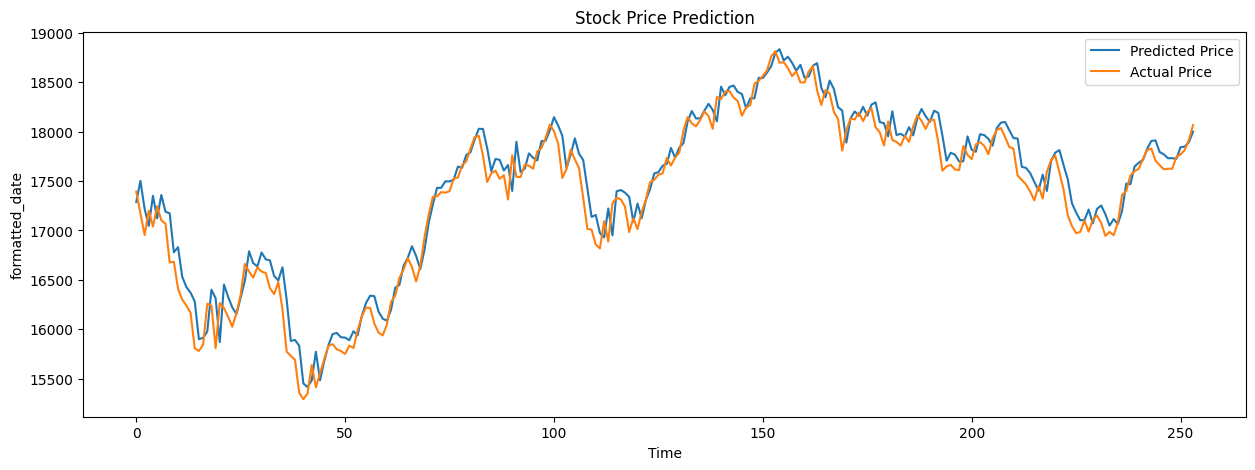

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(predicted_stock_price, label='Predicted Price')
plt.plot(scaler.inverse_transform(test_data), label='Actual Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.ylabel('formatted_date')
plt.legend()


This code is used to plot the predicted and actual stock prices. The `plt.figure(figsize=(15, 5))` function sets the size of the plot. The `plt.plot(predicted_stock_price, label='Predicted Price')` function plots the predicted stock prices with a label "Predicted Price". The `plt.plot(scaler.inverse_transform(test_data), label='Actual Price')` function plots the actual stock prices with a label "Actual Price". 


The `plt.title('Stock Price Prediction')` function sets the title of the plot to "Stock Price Prediction". The `plt.xlabel('Time')` and `plt.ylabel('Stock Price')` functions set the labels for the x and y axes, respectively. The `plt.legend()` function shows a legend on the plot which distinguishes between the predicted and actual prices.


The `plt.ylabel('formatted_date')` line seems to be incorrect and should be removed as it doesn't make sense in the context of this code.

We can see that the model has nicely been trained as the prediction and accuracy is almost the same

In [ ]:
model.save('stock_lstm_model.h5')


This line of code saves the trained LSTM model as an h5 file called `stock_lstm_model.h5`. The h5 file format is commonly used to store and serialize large amounts of data, including trained machine learning models. This allows the trained model to be loaded and used later for making predictions without having to retrain the model every time.

In [ ]:
start_date = df['formatted_date'].iloc[-1]

# create a DatetimeIndex with the desired frequency and starting date
date_rng = pd.date_range(start=start_date, periods=11, freq='b')[1:]

# get the last look_back days of data
last_data = data[-look_back:].values.reshape(-1, 1)
last_data = scaler.transform(last_data)

# create an empty list to store the predicted stock prices
forecast = []

# loop through each business day in the date_rng
for i in range(len(date_rng)):
    # reshape the last_data to fit the model input shape
    X_test = last_data.reshape(1, look_back, 1)

    # make the prediction
    predicted_price = model.predict(X_test)

    # append the predicted price to the forecast list
    forecast.append(predicted_price[0][0])

    # update the last_data with the predicted price
    last_data = np.vstack((last_data[1:], predicted_price))

# scale the forecasted prices back to the original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# create a DataFrame with the forecasted prices and the corresponding dates
forecast_df = pd.DataFrame(forecast, index=date_rng, columns=['Forecast'])

# print the forecasted prices
print(forecast_df)


1/1 [==============================] - 0s 36ms/step
                Forecast
2023-05-01  18139.568359
2023-05-02  18197.392578
2023-05-03  18257.365234
2023-05-04  18322.390625
2023-05-05  18385.988281
2023-05-08  18445.884766
2023-05-09  18502.210938
2023-05-10  18555.365234
2023-05-11  18605.468750
2023-05-12  18652.552734


The code is used to generate a forecast for the stock prices. 

- `start_date` is the last date in the data set.
- `date_rng` is a range of 11 business days with a frequency of 'b' (business days). 
- `last_data` is the last `look_back` days of data in the data set, which is scaled using the `scaler` used during training. 
- An empty list `forecast` is created to store the predicted stock prices.
- A loop is run for each business day in `date_rng`. In each iteration:
  - `X_test` is the last `look_back` days of data in `last_data` reshaped to fit the model input shape.
  - `predicted_price` is the predicted stock price based on `X_test` using the trained model.
  - `predicted_price` is appended to the `forecast` list.
  - `last_data` is updated by removing the oldest data point and appending the predicted price.
- The `forecast` list is converted back to the original scale using the `scaler`.
- `forecast_df` is a DataFrame containing the forecasted prices and corresponding dates.

In the forecasted prices are printed.